# Проект "HR-аналитика"

## Описание проекта

Мы HR-аналитики компании «Работа с заботой», которые помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
<br>
 
<br>Нам поставлено несколько задач:  
<br>Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.  Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. 
<br> 
<br>Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Задача №1: предсказание уровня удовлетворённости сотрудника

### Описание задачи

Для этой задачи заказчик предоставил данные с признаками: 
<br>
id — уникальный идентификатор сотрудника; 
<br>
dept — отдел, в котором работает сотрудник; 
<br>
level — уровень занимаемой должности; 
<br>
workload — уровень загруженности сотрудника; 
<br>
employment_years — длительность работы в компании (в годах); 
<br>
last_year_promo — показывает, было ли повышение за последний год; 
<br>
last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год; 
<br>
supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель; 
<br>
salary — ежемесячная зарплата сотрудника; 
<br>
job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Предоставленные файлы с данными:
<br>
Тренировочная выборка: train_job_satisfaction_rate.csv
<br>
Входные признаки тестовой выборки: test_features.csv
<br>
Целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv


### Загрузка данных

In [1]:
# Загрузим необходимые библиотеки
!pip install shap -q
!pip install scikit-learn==1.1.3 -q
!pip -q install phik
!pip install optuna-integration

In [2]:
# Импортируем необходимые нам библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from scipy import stats as st
from scipy.stats import binom, norm, spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    mean_absolute_error, 
    accuracy_score, 
    confusion_matrix, 
    recall_score, 
    precision_score, 
    roc_auc_score, 
    f1_score,
    make_scorer
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from optuna.integration import OptunaSearchCV 

import shap

In [3]:
# Загрузим данные тренировочной выборки train_job_satisfaction_rate.csv, выбрав верный разделитель. 
# Ознакомимся с содержимым.
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep = ',', decimal='.')
train_job_satisfaction_rate.info()
train_job_satisfaction_rate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


In [4]:
# Загрузим целевой признак тестовой выборки test_target_job_satisfaction_rate.csv, выбрав верный разделитель. 
# Ознакомимся с содержимым.
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep = ',', decimal='.')
test_target_job_satisfaction_rate.info()
test_target_job_satisfaction_rate.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [5]:
# Загрузим данные входных признаков тестовой выборки test_features.csv, выбрав верный разделитель. 
# Ознакомимся с содержимым.
test_features = pd.read_csv('/datasets/test_features.csv', sep = ',', decimal='.')
test_features.info()
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Данные загрузились корректно, типы данных определились верно. Тренировочная выборка содержит 4000 строк 10 колонок, тестовая выборка содержит 2000 строк и разделена на два датасета, отдельно с входными признаками и целевым, в сумме также 9 колонок с признаками + 'id'. Все три таблицы содержат столбец 'id', которые следует назначить индексом, осуществим это на этапе подготовки данных. Часть данных содержит пропуски, их заполнение возложим на этап преобработки с составе итогового пайплайна.

### Предобработка данных

In [6]:
# Проверим данные на наличие дубликатов 'id'
print(train_job_satisfaction_rate.duplicated(['id']).sum())
print(test_features.duplicated(['id']).sum())
print(test_target_job_satisfaction_rate.duplicated(['id']).sum())

0
0
0


In [7]:
# Проверим данные train_job_satisfaction_rate на наличие опечаток
print(train_job_satisfaction_rate['dept'].unique())
print(train_job_satisfaction_rate['level'].unique())
print(train_job_satisfaction_rate['workload'].unique())
print(train_job_satisfaction_rate['last_year_promo'].unique())
print(train_job_satisfaction_rate['last_year_violations'].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']


На первый взгляд с данными все нормально, единственное следует исправить 'sinior' на 'senior'.

In [8]:
# Исправим выявленые опечатки в столбце 'level' 
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace('sinior', 'senior')
train_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [9]:
# Проверим данные test_features на наличие опечаток
print(test_features['dept'].unique())
print(test_features['level'].unique())
print(test_features['workload'].unique())
print(test_features['last_year_promo'].unique())
print(test_features['last_year_violations'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


Аналогично следует исправить 'sinior' на 'senior'. Добавились пустые значения (пробелы).

In [10]:
# Исправим выявленые опечатки в столбце 'level' 
test_features['level'] = test_features['level'].replace('sinior', 'senior')
test_features['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [11]:
# И выведем строки с "пробелом"
test_features[(test_features == ' ').any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


In [12]:
# Заменим их на 'nan'
test_features = test_features.replace(' ', np.nan)
test_features[(test_features == ' ').any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


С остальными пропусками будем разбираться в рамкам пайплана

### Исследовательский анализ данных

In [13]:
# Создадим функцию вывода круговой диаграммы для категориальных данных
def pie_cat (data, col, title, label):
    group_tab = data.groupby(col).size()/len(data)
    group_tab.plot(kind='pie', autopct = '%1.0f%%')
    plt.title(f'{title}')
    plt.ylabel(f'{label}')
    plt.show() 

In [14]:
# Создадим функцию вывода гистограммы распределения для числовых данных
def hist_num (data, col, title, label, bins):
    plt.figure(figsize=(10, 6))
    data[col].plot(kind = 'hist', grid=True, bins=bins)
    plt.title(f'{title}')
    plt.ylabel('Частота')
    plt.xlabel(f'{label}')
    plt.show()
    display(data[col].describe())

#### train_job_satisfaction_rate

Начнем исследовательский анализ с данных train_job_satisfaction_rate

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


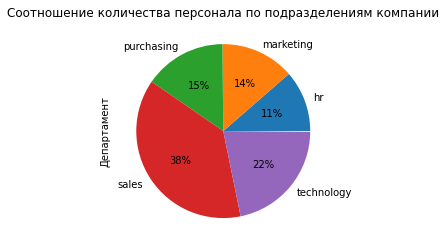

In [15]:
# Выведем диаграмму соотношения количества персонала по подразделениям компании
data=train_job_satisfaction_rate
col='dept'
title='Соотношение количества персонала по подразделениям компании'
label='Департамент'
pie_cat(data, col, title, label)

Вот такое распределение. Впрочем, информации о кампании и ее деятельности у нас нет.

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


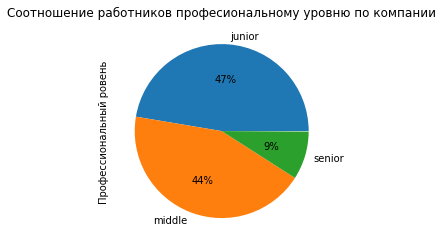

In [16]:
# Выведем диаграмму соотношения работников профессиональному уровню в компании
data=train_job_satisfaction_rate
col='level'
title='Соотношение работников професиональному уровню по компании'
label='Профессиональный ровень'
pie_cat(data, col, title, label)

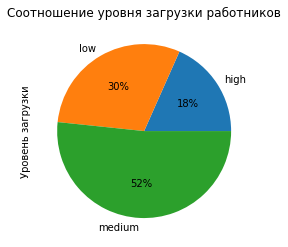

In [17]:
# Выведем диаграмму соотношение нагрузки на работников
data=train_job_satisfaction_rate
col='workload'
title='Соотношение уровня загрузки работников'
label='Уровень загрузки'
pie_cat(data, col, title, label)

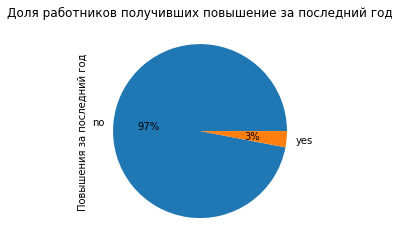

In [18]:
# Выведем диаграмму распределения повышений работников за последний год
data=train_job_satisfaction_rate
col='last_year_promo'
title='Доля работников получивших повышение за последний год'
label='Повышения за последний год'
pie_cat(data, col, title, label)

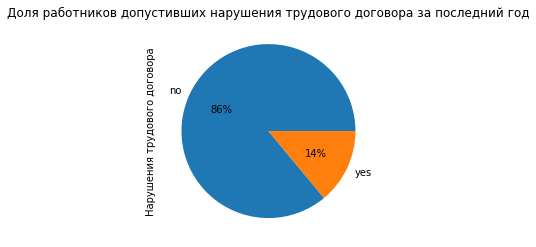

In [19]:
# Выведем диаграмму доли работников допустивших нарушения трудового договора за последний год
data=train_job_satisfaction_rate
col='last_year_violations'
title='Доля работников допустивших нарушения трудового договора за последний год'
label='Нарушения трудового договора'
pie_cat(data, col, title, label)

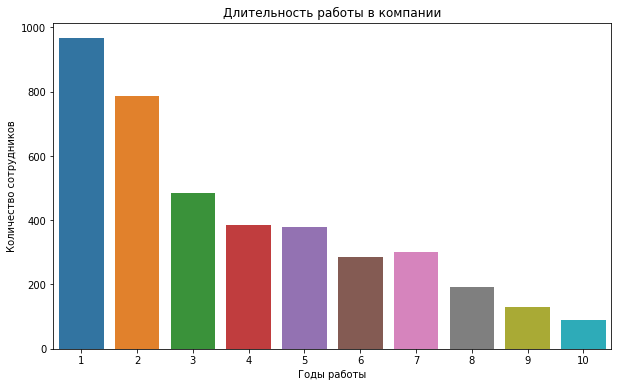

In [20]:
# Выведем диаграмму распределения стажа работы сотрудников в компании
plt.figure(figsize=(10, 6))
sns.countplot(x ='employment_years', data = train_job_satisfaction_rate).set(
    title='Длительность работы в компании', xlabel='Годы работы', ylabel='Количество сотрудников');

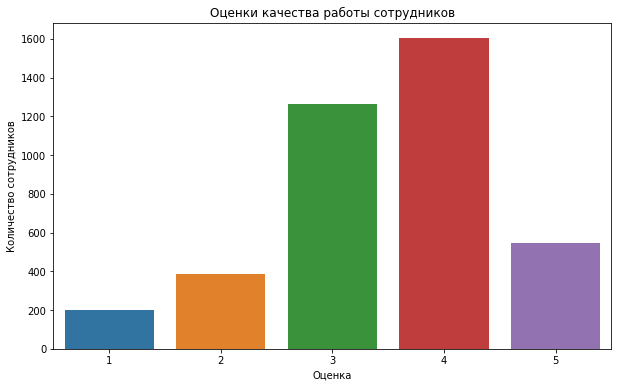

In [21]:
# Выведем диаграмму распределения оценок качества работы сотрудников
plt.figure(figsize=(10, 6))
sns.countplot(x ='supervisor_evaluation', data = train_job_satisfaction_rate).set(
    title='Оценки качества работы сотрудников', xlabel='Оценка', ylabel='Количество сотрудников');

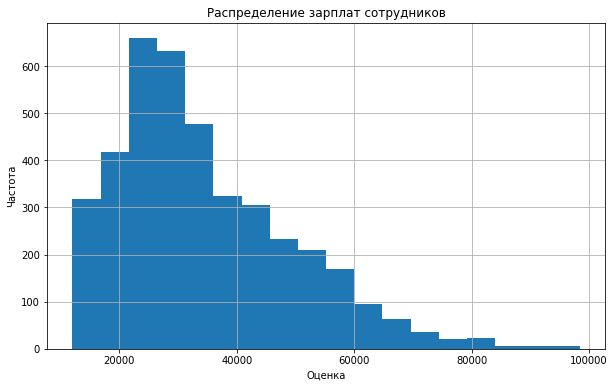

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

In [22]:
# Выведем диаграмму распределения зарплат сотрудников
data=train_job_satisfaction_rate
col='salary'
title='Распределение зарплат сотрудников'
label='Оценка'
bins=18
hist_num(data, col, title, label, bins)

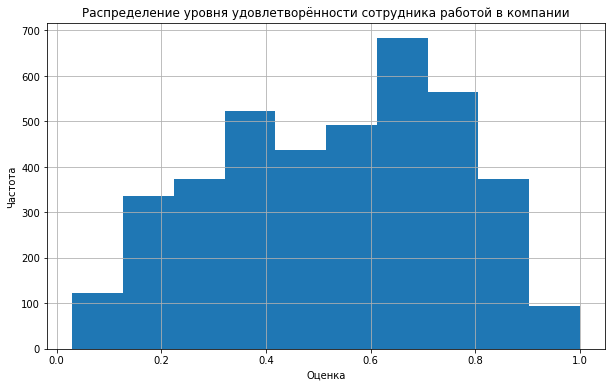

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [23]:
# Выведем диаграмму распределения уровня удовлетворённости сотрудника работой в компании
data=train_job_satisfaction_rate
col='job_satisfaction_rate'
title='Распределение уровня удовлетворённости сотрудника работой в компании'
label='Оценка'
bins=10
hist_num(data, col, title, label, bins)

#### test_features

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


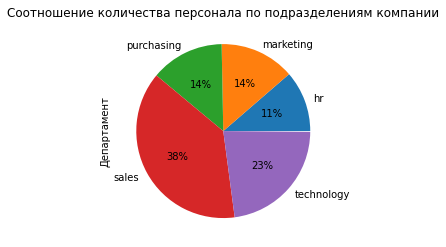

In [24]:
# Выведем диаграмму соотношения количества персонала по подразделениям компании
data=test_features
col='dept'
title='Соотношение количества персонала по подразделениям компании'
label='Департамент'
pie_cat(data, col, title, label)

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


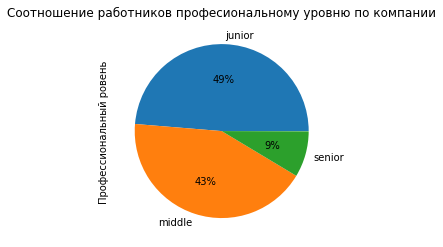

In [25]:
# Выведем диаграмму соотношения работников профессиональному уровню в компании
data=test_features
col='level'
title='Соотношение работников професиональному уровню по компании'
label='Профессиональный ровень'
pie_cat(data, col, title, label)

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


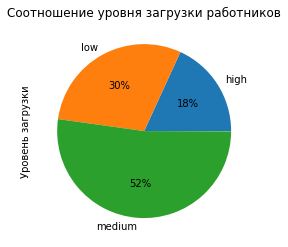

In [26]:
# Выведем диаграмму соотношение нагрузки на работников
data=test_features
col='workload'
title='Соотношение уровня загрузки работников'
label='Уровень загрузки'
pie_cat(data, col, title, label)

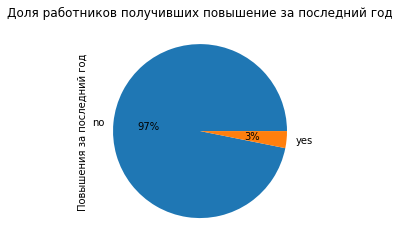

In [27]:
# Выведем диаграмму распределения повышений работников за последний год
data=test_features
col='last_year_promo'
title='Доля работников получивших повышение за последний год'
label='Повышения за последний год'
pie_cat(data, col, title, label)

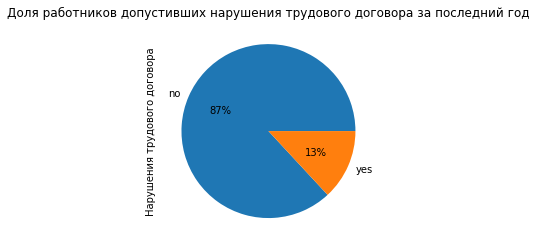

In [28]:
# Выведем диаграмму доли работников допустивших нарушения трудового договора за последний год
data=test_features
col='last_year_violations'
title='Доля работников допустивших нарушения трудового договора за последний год'
label='Нарушения трудового договора'
pie_cat(data, col, title, label)

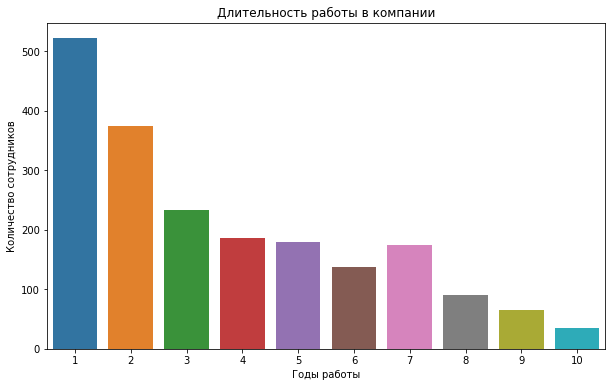

In [29]:
# Выведем диаграмму распределения стажа работы сотрудников в компании
plt.figure(figsize=(10, 6))
sns.countplot(x ='employment_years', data = test_features).set(
    title='Длительность работы в компании', xlabel='Годы работы', ylabel='Количество сотрудников');

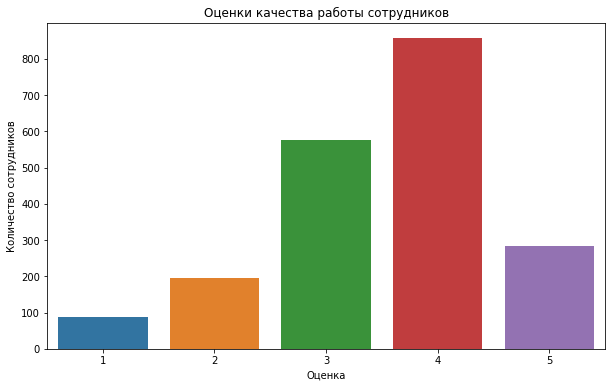

In [30]:
# Выведем диаграмму распределения оценок качества работы сотрудников
plt.figure(figsize=(10, 6))
sns.countplot(x ='supervisor_evaluation', data = test_features).set(
    title='Оценки качества работы сотрудников', xlabel='Оценка', ylabel='Количество сотрудников');

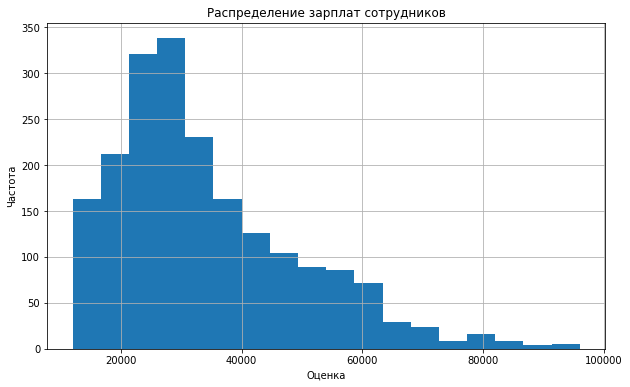

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [31]:
# Выведем диаграмму распределения зарплат сотрудников
data=test_features
col='salary'
title='Распределение зарплат сотрудников'
label='Оценка'
bins=18
hist_num(data, col, title, label, bins)

#### test_target_job_satisfaction_rate

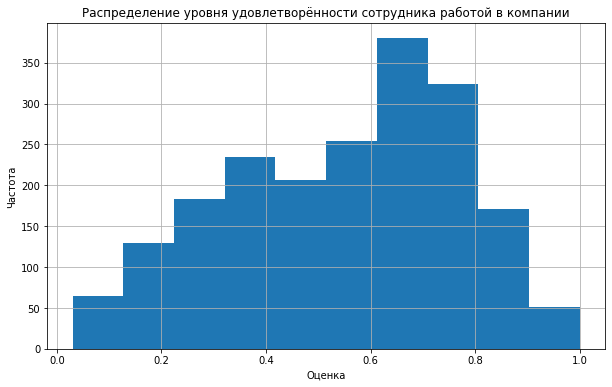

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

In [32]:
# Выведем диаграмму распределения уровня удовлетворённости сотрудника работой в компании
data=test_target_job_satisfaction_rate
col='job_satisfaction_rate'
title='Распределение уровня удовлетворённости сотрудника работой в компании'
label='Оценка'
bins=10
hist_num(data, col, title, label, bins)

In [33]:
# Сравним параметры распределений тестовой и тренирововчной выборок 
print(train_job_satisfaction_rate. describe())
print(test_features. describe())
print(test_target_job_satisfaction_rate. describe())

                  id  employment_years  supervisor_evaluation        salary  \
count    4000.000000       4000.000000            4000.000000   4000.000000   
mean   544957.621000          3.718500               3.476500  33926.700000   
std    257883.104622          2.542513               1.008812  14900.703838   
min    100954.000000          1.000000               1.000000  12000.000000   
25%    322836.750000          2.000000               3.000000  22800.000000   
50%    534082.500000          3.000000               4.000000  30000.000000   
75%    771446.000000          6.000000               4.000000  43200.000000   
max    999521.000000         10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            4000.000000  
mean                0.533995  
std                 0.225327  
min                 0.030000  
25%                 0.360000  
50%                 0.560000  
75%                 0.710000  
max                 1.000000  
         

Рапределения данных вопросов не вызывают. Параметры распределений тестовой и тренировочной выборок по всем числовым признакам максимально близки.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> EDA признаков выполнен.

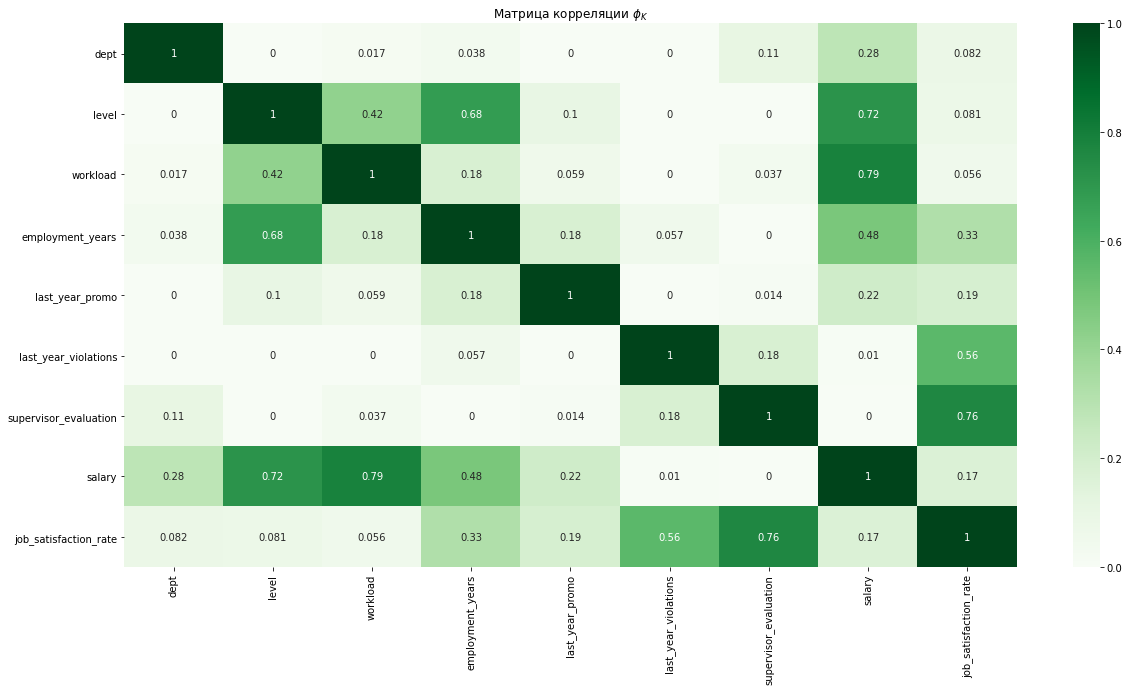

In [34]:
# Выведем матрицу корреляции
target_matrix = train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])
plt.figure(figsize=(20, 10))
sns.heatmap(target_matrix, annot=True, cmap='Greens')
plt.title('Матрица корреляции $\phi_K$')
plt.show()

In [35]:
# Выделим и отсортируем коэффициенты корреляции с нашим целевым признаком
target_matrix['job_satisfaction_rate'].sort_values(ascending=False)

job_satisfaction_rate    1.000000
supervisor_evaluation    0.764364
last_year_violations     0.560348
employment_years         0.325603
last_year_promo          0.190803
salary                   0.165830
dept                     0.082086
level                    0.080620
workload                 0.056128
Name: job_satisfaction_rate, dtype: float64

Наилучшая корреляция с целевым признаком у параметра 'supervisor_evaluation' (уровень удовлетворённости сотрудника работой в компании), заметно меньше у 'last_year_violations' (нарушения сотрудником трудового договора). У остальных параметров корреляция с целевым признаком слабая. Оснований для мультиколлиниарности не наблюдается.

Проведем аналогичный корреляционный анализ для тестовых данных

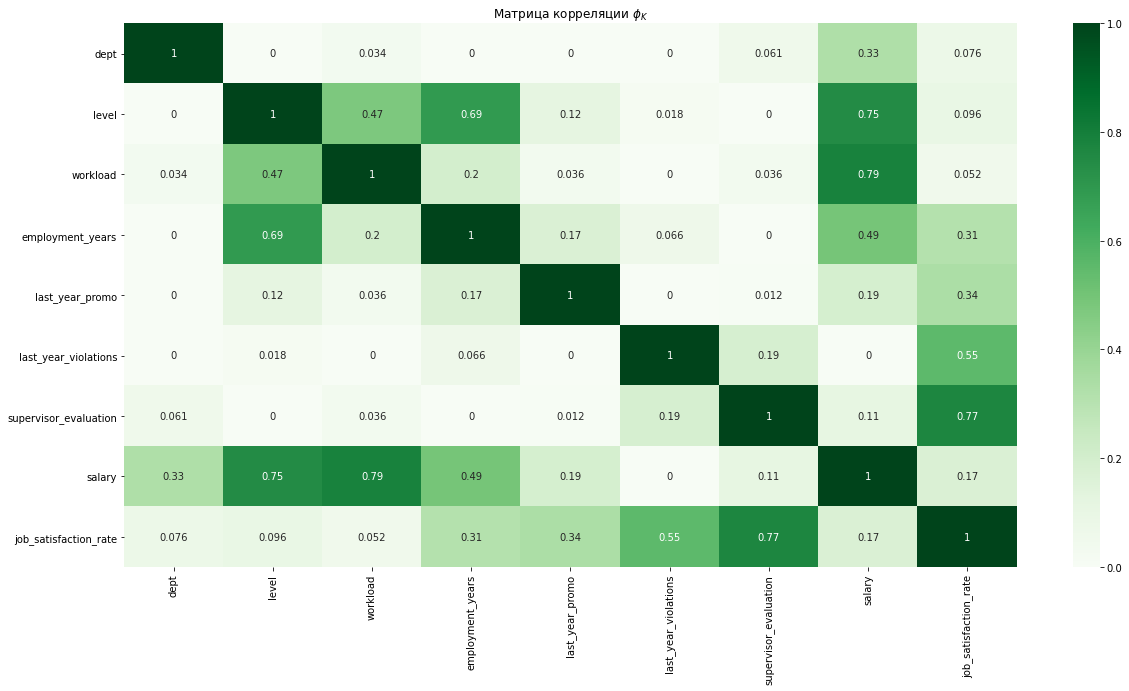

In [37]:
# Выведем матрицу корреляции для тестовых данных
target_matrix = test_data.drop('id', axis=1).phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])
plt.figure(figsize=(20, 10))
sns.heatmap(target_matrix, annot=True, cmap='Greens')
plt.title('Матрица корреляции $\phi_K$')
plt.show()

In [38]:
# Выделим и отсортируем коэффициенты корреляции с нашим целевым признаком
target_matrix['job_satisfaction_rate'].sort_values(ascending=False)

job_satisfaction_rate    1.000000
supervisor_evaluation    0.769857
last_year_violations     0.554811
last_year_promo          0.337002
employment_years         0.313525
salary                   0.171903
level                    0.095706
dept                     0.075774
workload                 0.052308
Name: job_satisfaction_rate, dtype: float64

Коэффициенты корреляции тестовых данных близки к аналогичным коэффициентам тренировочной выборки.

### Подготовка данных

По условиям задачи подготовка данных (заполнение пропусков) возлагается на отдельный пайплайн. Заполнять пропуски будем самыми частыми значениями, для кодировки категориальных признаков используем два кодировщика.

In [39]:
# Фиксируем константы
RANDOM_STATE = 42


In [40]:
# Удалим столбец 'id' в тренировочной выборке и проверим наличие дубликатов после удаления
train_job_satisfaction_rate = train_job_satisfaction_rate.drop(['id'], axis=1)
train_job_satisfaction_rate.duplicated().sum()

245

In [41]:
# Удалим выявленные дубликаты
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates().reset_index(drop=True)
train_job_satisfaction_rate.duplicated().sum()

0

In [42]:
# Обозначим тренировочную и тестовую выборки X_train, X_test, y_train, y_test 
X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
X_test = test_data.drop(['job_satisfaction_rate','id'], axis=1)
y_test = test_data['job_satisfaction_rate']


# создадим списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# создадим пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore',  sparse=False))
    ]
    )
# создадим пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и ORD-кодирование
# SimpleImputer + ORD
ord_pipe = Pipeline(
    [('simple_imputer_ord_before', 
      SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
     ('ord', OrdinalEncoder(categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']], 
                            handle_unknown='use_encoded_value', unknown_value=np.nan)), 
     ('simple_imputer_ord_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [43]:
# создадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение моделей

In [44]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [45]:
# Подготовим модели с гиперпараметрами

param_grid = [
     # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 15),
        'models__min_samples_leaf': range(5, 15),
        'models__min_samples_split': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Запустим случайный поиск лучшей модели передав ей список словарей с моделями и их гиперпараметрами.
Метрику для выбора лучшей модели выберем SMAPE. В Python нет встроенной функции для вычисления SMAPE, но мы можем создать для этого простую функцию:

In [46]:
def smape(y_true, y_pred):
    return 1/ len (y_true) * np.sum (2 * np.abs (y_pred-y_true) / (np.abs (y_true) + np.abs (y_pred))*100)
smape_scorer = make_scorer(smape, greater_is_better=False)

In [47]:
# Запустим случайный поиск лучшей модели передав ей список словарей с моделями и их гиперпараметрами.
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE
)

In [48]:
randomized_search.fit(X_train, y_train)
best_model = randomized_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [49]:
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape(y_test, best_model.predict(X_test)),4)}')

Метрика SMAPE лучшей модели на тестовой выборке: 14.0466


### Вывод по задаче №1

Для решения первой задачи мы изучили предоставленные данные, заполнили пропуски наиболее частыми значениями и подготовили для обучения моделей. Для кодировки категориальных признаков использовали два кодировщика. Затем провели обучения двумя линейными моделями - Линейной регрессии и Деревом решений, с перебором гиперпараметров. Для оценки использовали метрику SMAPE. По результатам рандомного поиска лучшей моделью стала DecisionTreeRegressor, с гиперпараметрами max_depth=19, max_features=5, min_samples_leaf=5, min_samples_split=11.
<br>
Метрика SMAPE лучшей модели на тренировочной выборке: 12.6764
<br>
Метрика SMAPE лучшей модели на тестовой выборке: 14.0466

## Задача №2

### Описание задачи

Для этой задачи нам необходимо использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.
<br>
Необходимо провести исследовательский анализ данных, обучить модели с перебором гиперпараметров. Выбрать лучшую модель операясь на метрику 'roc_auc'. Проанализировать результаты моделирования, определить признаки влияющие на вероятность увольнения сотрудника.

### Загрузка данных

In [50]:
# Загрузим данные тренировочной выборки test_target_quit.csv, выбрав верный разделитель. 
# Ознакомимся с содержимым.
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv', sep = ',', decimal='.')
test_target_quit.info()
test_target_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [51]:
# Загрузим данные тренировочной выборки train_quit.csv, выбрав верный разделитель. 
# Ознакомимся с содержимым.
train_quit = pd.read_csv('/datasets/train_quit.csv', sep = ',', decimal='.')
train_quit.info()
train_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Данные загружены. Явные пропуски отсутствуют. Тип данных в порядке, замечаний по содержанию нет.

### Предобработка данных

In [52]:
# Проверим данные на наличие дубликатов 'id'
print(train_quit.duplicated(['id']).sum())
print(test_target_quit.duplicated(['id']).sum())

0
0


In [53]:
# Проверим данные test_target_quit на наличие опечаток и пропусков
print(test_target_quit['quit'].unique())

['yes' 'no']


Ни дубликатов, ни пропусков с опечатками не обнаружено.

In [54]:
# Проверим данные train_quit на наличие опечаток
print(train_quit['dept'].unique())
print(train_quit['level'].unique())
print(train_quit['workload'].unique())
print(train_quit['last_year_promo'].unique())
print(train_quit['last_year_violations'].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']


Опечаток нет, осталось исправить 'sinior' на 'senior' в столбце 'level'

In [55]:
# Исправим выявленые ошибки в столбце 'level' 
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

### Исследовательский анализ данных

#### test_data

In [56]:
# Для начала добавим к тестовым данным данные об увольнениях
test_data = test_data.merge(test_target_quit, on='id')
test_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


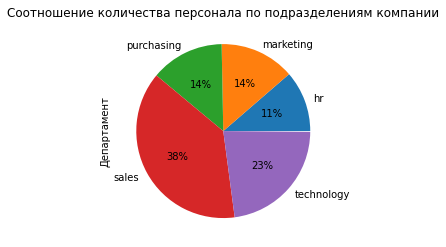

In [57]:
# Выведем диаграмму соотношения количества персонала по подразделениям компании
data=test_data
col='dept'
title='Соотношение количества персонала по подразделениям компании'
label='Департамент'
pie_cat(data, col, title, label)

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


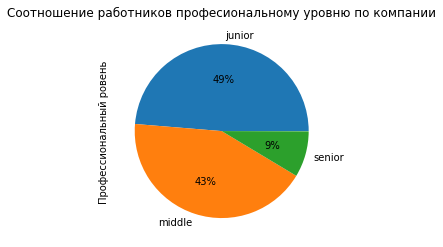

In [58]:
# Выведем диаграмму соотношения работников профессиональному уровню в компании
data=test_data
col='level'
title='Соотношение работников професиональному уровню по компании'
label='Профессиональный ровень'
pie_cat(data, col, title, label)

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


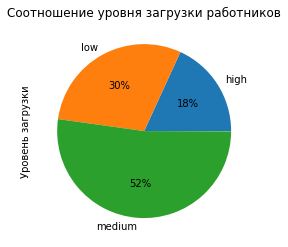

In [59]:
# Выведем диаграмму соотношение нагрузки на работников
data=test_data
col='workload'
title='Соотношение уровня загрузки работников'
label='Уровень загрузки'
pie_cat(data, col, title, label)

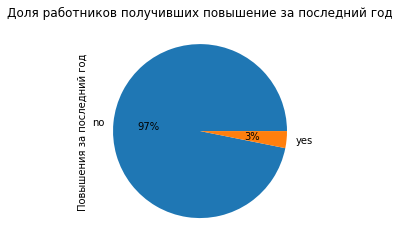

In [60]:
# Выведем диаграмму распределения повышений работников за последний год
data=test_data
col='last_year_promo'
title='Доля работников получивших повышение за последний год'
label='Повышения за последний год'
pie_cat(data, col, title, label)

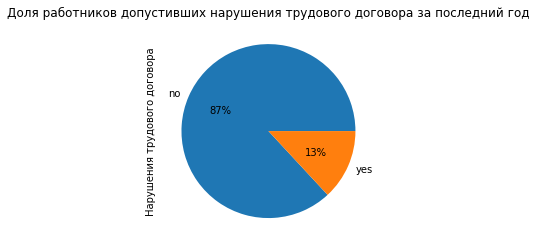

In [61]:
# Выведем диаграмму доли работников допустивших нарушения трудового договора за последний год
data=test_data
col='last_year_violations'
title='Доля работников допустивших нарушения трудового договора за последний год'
label='Нарушения трудового договора'
pie_cat(data, col, title, label)

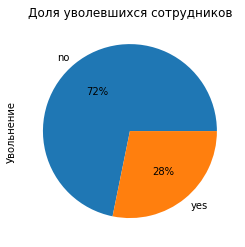

In [62]:
# Выведем долю уволевшихся сотрудников
data=test_data
col='quit'
title='Доля уволевшихся сотрудников'
label='Увольнение'
pie_cat(data, col, title, label)

Далее, проведем корреляционный анализ, рассмотрим признаки коррелирующиеся с нашим целевым признаком 'quit'

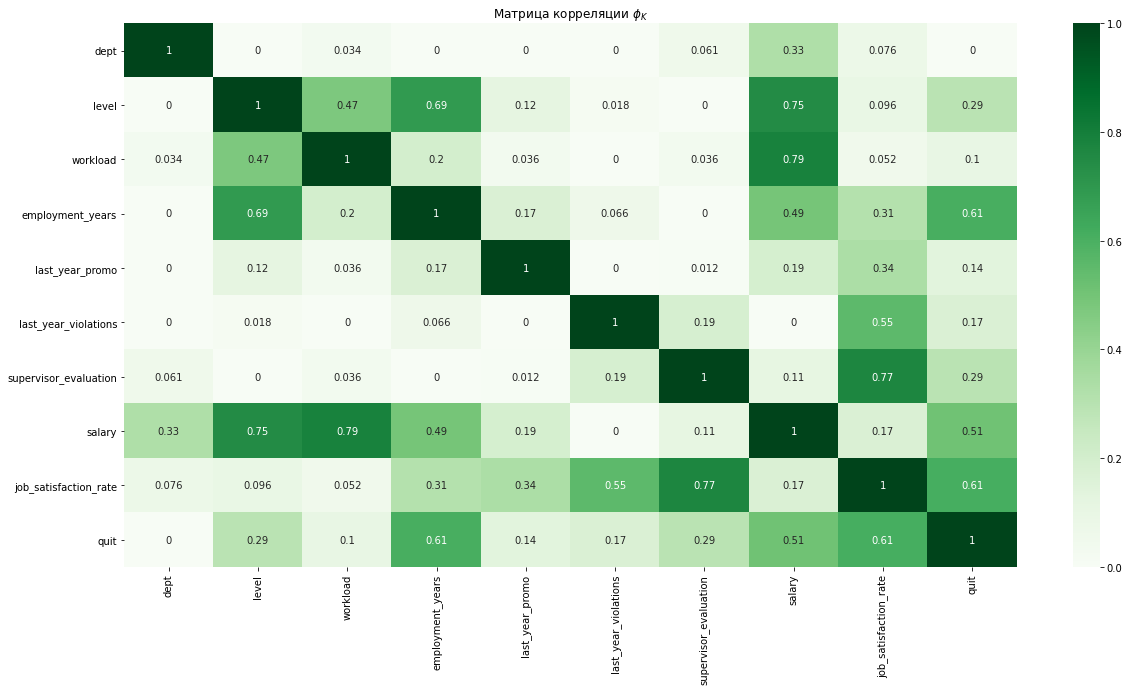

In [63]:
# Выведем матрицу корреляции
target_matrix = test_data.drop(['id'], axis=1).phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])
plt.figure(figsize=(20, 10))
sns.heatmap(target_matrix, annot=True, cmap='Greens')
plt.title('Матрица корреляции $\phi_K$')
plt.show()

In [64]:
# Выделим и отсортируем коэффициенты корреляции с нашим целевым признаком
target_matrix['quit'].sort_values(ascending=False)

quit                     1.000000
job_satisfaction_rate    0.610263
employment_years         0.605927
salary                   0.508308
supervisor_evaluation    0.294738
level                    0.293623
last_year_violations     0.174740
last_year_promo          0.137762
workload                 0.102151
dept                     0.000000
Name: quit, dtype: float64

Лучшую корреляцию с целевым признаком имеют 'job_satisfaction_rate', 'employment_years' и 'salary'. Хуже коррелируются 'supervisor_evaluation', 'level'. У остальных коэффициент корреляции минимален.
<br>
Сравним распределение уровня удовлетворенности ('job_satisfaction_rate') у уволившихся и неуволившихся сотрудников.

In [65]:
# Создадим функцию для сравнения гистограмм рапределения
def hist (df, col, target):
    plt.figure(figsize=(10,10))
    plot = sns.histplot(df, hue=target, x=col, stat='density', common_norm=False)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Плотность распределения', fontsize=14)

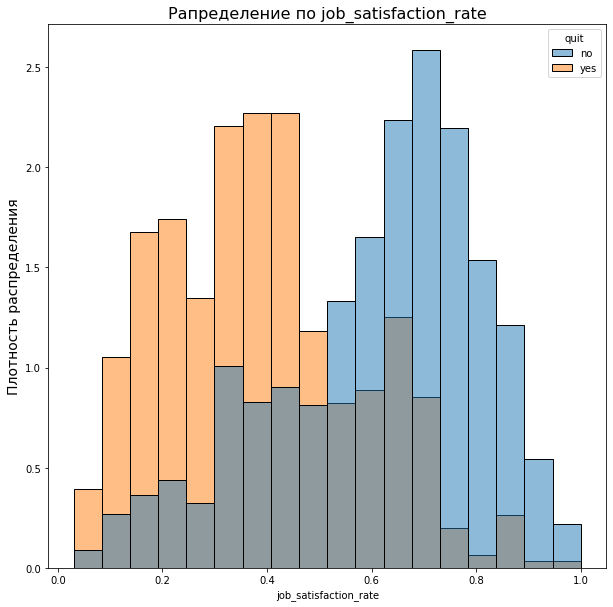

In [66]:
# Визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников
hist(test_data, 'job_satisfaction_rate', 'quit')

Распределения отличаются существенно, следовательно уровень удовлетворенности влияет на решение сотрудников продолжать работу в компании.

In [67]:
# Для составления портрета уволившегося сотрудника сгрупперуем данные по 'quit' со средними значениями числовых признаков
# 'salary', 'employment_years', 'supervisor_evaluation' и 'job_satisfaction_rate'
quit_pivot = test_data.pivot_table(index='quit', 
                                       values=['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate'], 
                                       aggfunc='mean'
                                      )
quit_pivot.columns = ['средний стаж работы в компании', 'уровень удовлетворенности', 'зарплата', 'оценка руководителя']
quit_pivot

,средний стаж работы в компании,уровень удовлетворенности,зарплата,оценка руководителя
quit,,,,
no,4.330780,0.612040,37645.403900,3.716574
yes,1.975177,0.387713,24955.319149,3.042553


По всем четырем признакам есть существенная разница в средних значениях. Проанализируем категориальные признаки.

quit,no,yes
dept,,
hr,0.713656,0.286344
marketing,0.759857,0.240143
purchasing,0.714286,0.285714
sales,0.703801,0.296199
technology,0.720879,0.279121


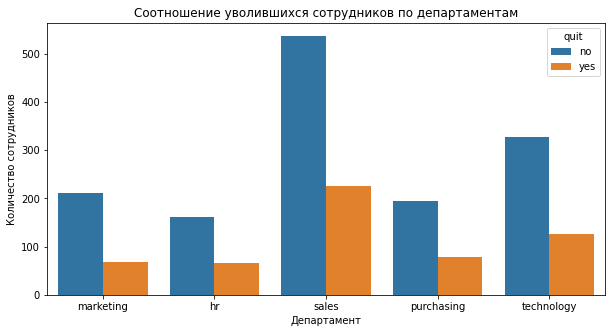

In [68]:
# Выведем соотношение уволившихся сотрудников по департаментам
data = test_data.groupby(['dept'])['quit'].value_counts(normalize=True)
plt.figure(figsize=(10,5))
sns.countplot(data=test_data, x='dept', hue='quit').set(xlabel='Департамент', ylabel='Количество сотрудников', 
                                                        title='Соотношение уволившихся сотрудников по департаментам');
data.unstack()

quit,no,yes
dept,,
hr,0.713656,0.286344
marketing,0.759857,0.240143
purchasing,0.714286,0.285714
sales,0.703801,0.296199
technology,0.720879,0.279121


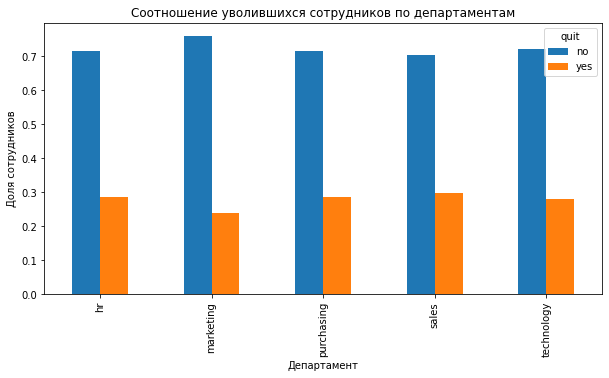

In [69]:
# Выведем соотношение уволившихся сотрудников по департаментам
data = test_data.groupby(['dept'])['quit'].value_counts(normalize=True)
data.unstack().plot(kind='bar', figsize=(10,5))
plt.title('Соотношение уволившихся сотрудников по департаментам')
plt.xlabel('Департамент')
plt.ylabel('Доля сотрудников')
data.unstack()

quit,no,yes
supervisor_evaluation,,
1,0.568182,0.431818
2,0.545918,0.454082
3,0.521739,0.478261
4,0.842474,0.157526
5,0.904930,0.095070


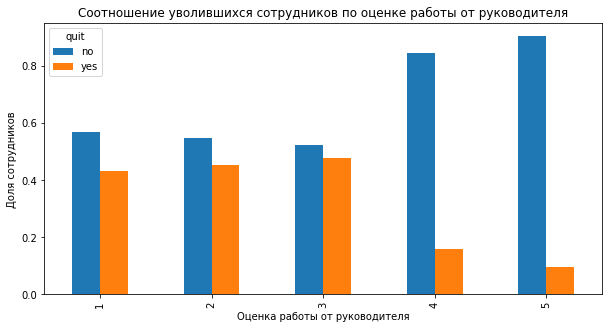

In [70]:
# Выведем соотношение уволившихся сотрудников по оценке работы от руководителя
data = test_data.groupby(['supervisor_evaluation'])['quit'].value_counts(normalize=True)
data.unstack().plot(kind='bar', figsize=(10,5))
plt.title('Соотношение уволившихся сотрудников по оценке работы от руководителя')
plt.xlabel('Оценка работы от руководителя')
plt.ylabel('Доля сотрудников')
data.unstack()

quit,no,yes
employment_years,,
1,0.442529,0.557471
2,0.612299,0.387701
3,0.653846,0.346154
4,0.925134,0.074866
5,0.960894,0.039106
6,0.978261,0.021739
7,0.925287,0.074713
8,0.978022,0.021978
9,0.909091,0.090909


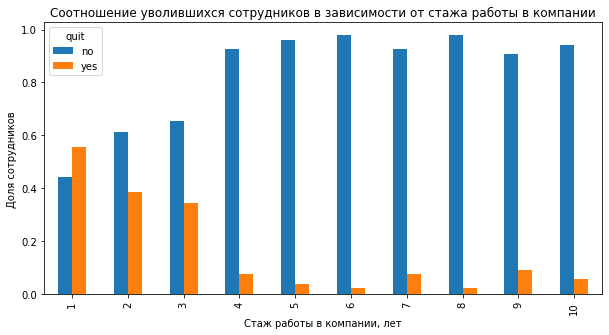

In [71]:
# Выведем соотношение уволившихся сотрудников в зависимости от стажа работы в компании
data = test_data.groupby(['employment_years'])['quit'].value_counts(normalize=True)
data.unstack().plot(kind='bar', figsize=(10,5))
plt.title('Соотношение уволившихся сотрудников в зависимости от стажа работы в компании')
plt.xlabel('Стаж работы в компании, лет')
plt.ylabel('Доля сотрудников')
data.unstack()

quit,no,yes
level,,
junior,0.498973,0.501027
middle,0.927400,0.072600
senior,0.923977,0.076023


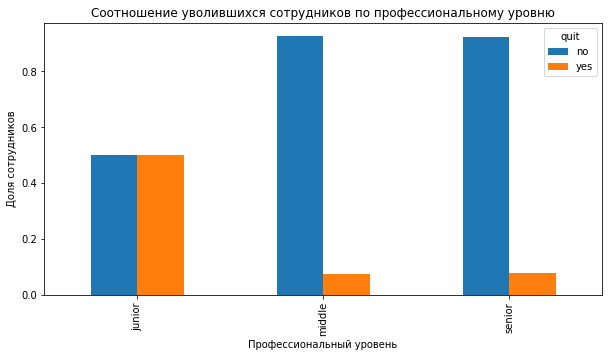

In [72]:
# Выведем соотношение уволившихся сотрудников по профессиональному уровню
data = test_data.groupby(['level'])['quit'].value_counts(normalize=True)
data.unstack().plot(kind='bar', figsize=(10,5))
plt.title('Соотношение уволившихся сотрудников по профессиональному уровню')
plt.xlabel('Профессиональный уровень')
plt.ylabel('Доля сотрудников')
data.unstack()


quit,no,yes
last_year_violations,,
no,0.738205,0.261795
yes,0.583969,0.416031


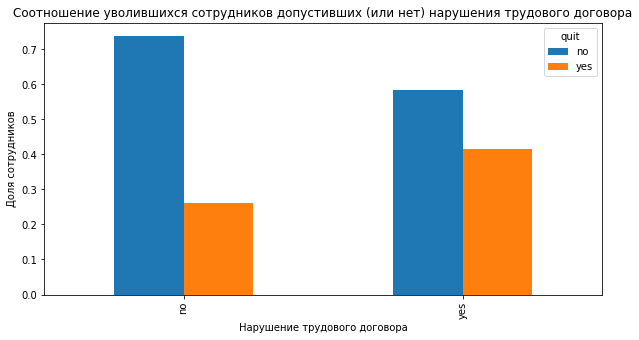

In [73]:
# Выведем соотношение уволившихся сотрудников допустивших (или нет) нарушения трудового договора
data = test_data.groupby(['last_year_violations'])['quit'].value_counts(normalize=True)
data.unstack().plot(kind='bar', figsize=(10,5))
plt.title('Соотношение уволившихся сотрудников допустивших (или нет) нарушения трудового договора')
plt.xlabel('Нарушение трудового договора')
plt.ylabel('Доля сотрудников')
data.unstack()

quit,no,yes
last_year_promo,,
no,0.710377,0.289623
yes,0.952381,0.047619


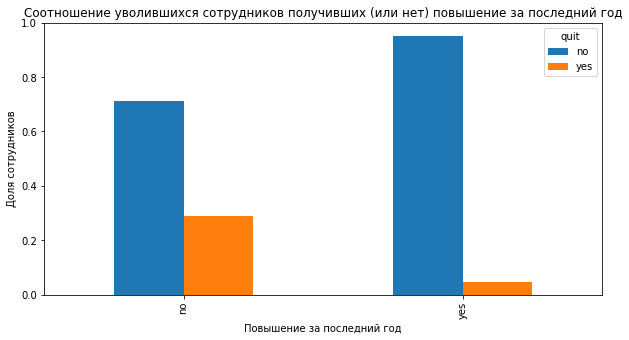

In [74]:
# Выведем соотношение уволившихся сотрудников получивших (или нет) повышение за последний год
data = test_data.groupby(['last_year_promo'])['quit'].value_counts(normalize=True)
data.unstack().plot(kind='bar', figsize=(10,5))
plt.title('Соотношение уволившихся сотрудников получивших (или нет) повышение за последний год')
plt.xlabel('Повышение за последний год')
plt.ylabel('Доля сотрудников')
data.unstack()

quit,no,yes
workload,,
high,0.793388,0.206612
low,0.600337,0.399663
medium,0.758389,0.241611


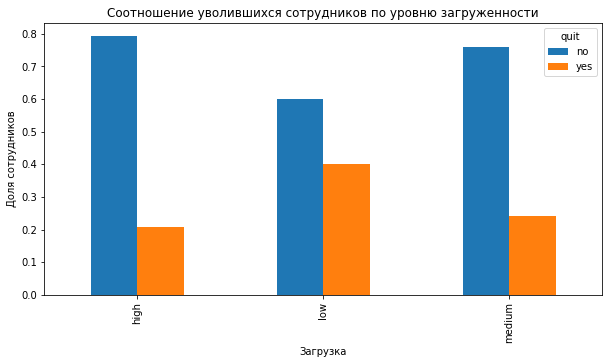

In [75]:
# Выведем соотношение уволившихся сотрудников по уровню загруженности
data = test_data.groupby(['workload'])['quit'].value_counts(normalize=True)
data.unstack().plot(kind='bar', figsize=(10,5))
plt.title('Соотношение уволившихся сотрудников по уровню загруженности')
plt.xlabel('Загрузка')
plt.ylabel('Доля сотрудников')
data.unstack()

За исключением 'dept', по всем остальным категориальным признакам есть разница в соотношении уволившихся и неуволившихся сотрудников. 


Составим "портрет" уволившегося сотрудника, он имеет:
1. небольшой стаж работы в компании
2. низкую зарплату
3. низкую оценку работы от руководителя
4. низкий профессиональный уровень
5. низкую загрузку
6. чаще нарушает трудовой договор
7. не имеет повышений за последний год
<br>
В совокупности это формирует низкую оценку удовлетворенности. Причем департамент, в котором работает условный работник не влияет на вероятность его увольнения.

#### train_quit

По результатам корреляционного анализа тестовых данных мы подтвердили важность признака 'job_satisfaction_rate', который отсутсвует в тренировочной выборке. Добавим его в выборку, воспользовавшись лучшей моделью из первой задачи.

In [76]:
# Добавим к тренировочным данным данные об удовлетворенности (job_satisfaction_rate) с помощью модели из первой задачи
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.643333
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846875
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.405714
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.668182


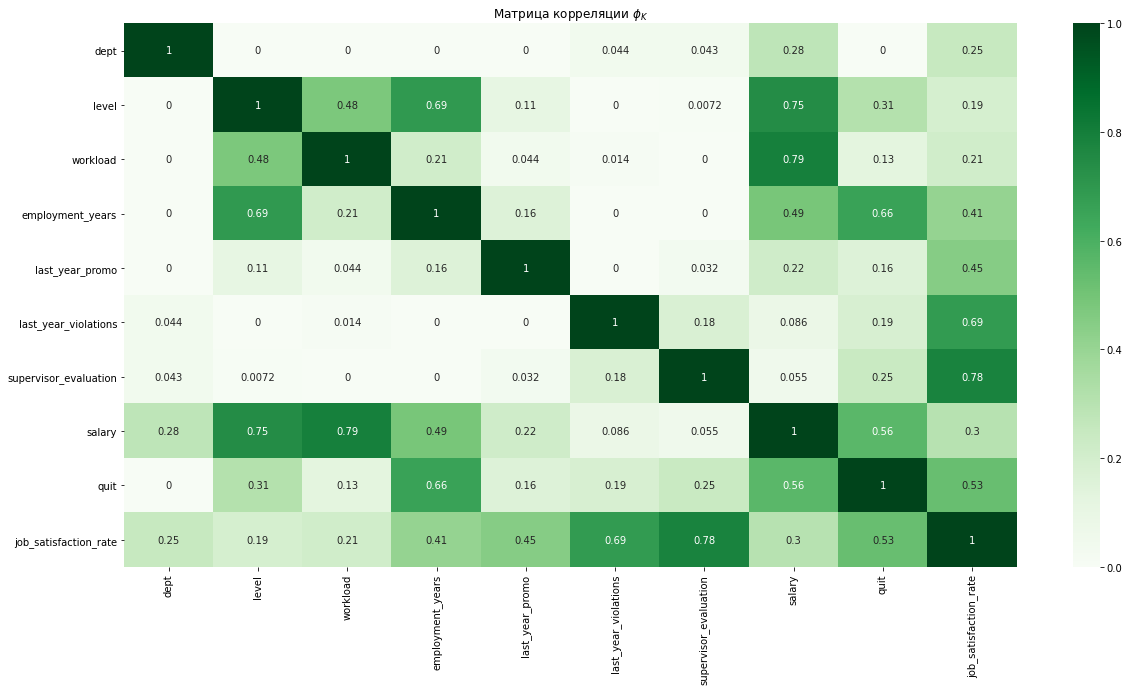

In [77]:
# Выведем матрицу корреляции
target_matrix = train_quit.drop('id', axis=1).phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])
plt.figure(figsize=(20, 10))
sns.heatmap(target_matrix, annot=True, cmap='Greens')
plt.title('Матрица корреляции $\phi_K$')
plt.show()

In [78]:
# Выделим и отсортируем коэффициенты корреляции с нашим целевым признаком
target_matrix['quit'].sort_values(ascending=False)

quit                     1.000000
employment_years         0.659093
salary                   0.564154
job_satisfaction_rate    0.529055
level                    0.312799
supervisor_evaluation    0.245489
last_year_violations     0.185071
last_year_promo          0.157370
workload                 0.132243
dept                     0.000000
Name: quit, dtype: float64

С нашим целевым признаком более менее коррелируются параметры 'employment_years', 'salary' и 'job_satisfaction_rate'. Как конкретно влияют эти признаки оценим на основе Shap-анализа по результатам моделирования.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.5 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

### Подготовка данных

In [79]:
# Заменим данные 'job_satisfaction_rate' в тестовой выборке на предсказанные нашей моделью из первой задачи
test_data.drop('job_satisfaction_rate', axis=1, inplace=True)
test_data['job_satisfaction_rate'] = best_model.predict(X_test)
test_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.856250
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.678750
2,467458,sales,middle,low,5,no,no,4,19200,no,0.655556
3,418655,sales,middle,low,6,no,no,4,19200,no,0.655556
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.747778


In [80]:
# Удалим столбец 'id' в тренировочной выборке и проверим наличие дубликатов после удаления
train_quit = train_quit.drop(['id'], axis=1)
train_quit.duplicated().sum()

1413

In [81]:
# Удалим выявленные дубликаты
train_quit = train_quit.drop_duplicates().reset_index(drop=True)
train_quit.duplicated().sum()

0

In [82]:
# Фиксируем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Обозначим тренировочную и тестовую выборки X_train, X_test, y_train, y_test 
X_train = train_quit.drop(['quit'], axis=1)
y_train = train_quit['quit']
X_test = test_data.drop(['quit','id'], axis=1)
y_test = test_data['quit']

In [83]:
# Закодируем целевой признак
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [84]:
# Зададим верный порядок классов
le.classes_ = np.array(['no', 'yes'])
le.classes_ 

array(['no', 'yes'], dtype='<U3')

In [85]:
# создадим списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# создадим пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore',  sparse=False))
    ]
    )

# создадим пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и ORD-кодирование
# SimpleImputer + ORD
ord_pipe = Pipeline(
    [('simple_imputer_ord_before', 
      SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
     ('ord', OrdinalEncoder(categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']], 
                            handle_unknown='use_encoded_value', unknown_value=np.nan)), 
     ('simple_imputer_ord_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [86]:
# создадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение модели

In [87]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Подготовим модели с гиперпараметрами

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability= True)],
        'models__degree': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

Запустим случайный поиск лучшей модели передав ей список словарей с моделями и их гиперпараметрами.
Метрику для выбора лучшей модели используем roc_auc.

In [88]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', round(randomized_search.best_score_, 3))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

Метрика ROC-AUC на кросс-валидационной выборке дала результат 0.903. Попробуем повысить качество за счет отбора входных признаков, для этого проанализируем работу модели с помощью Shap-анализа.

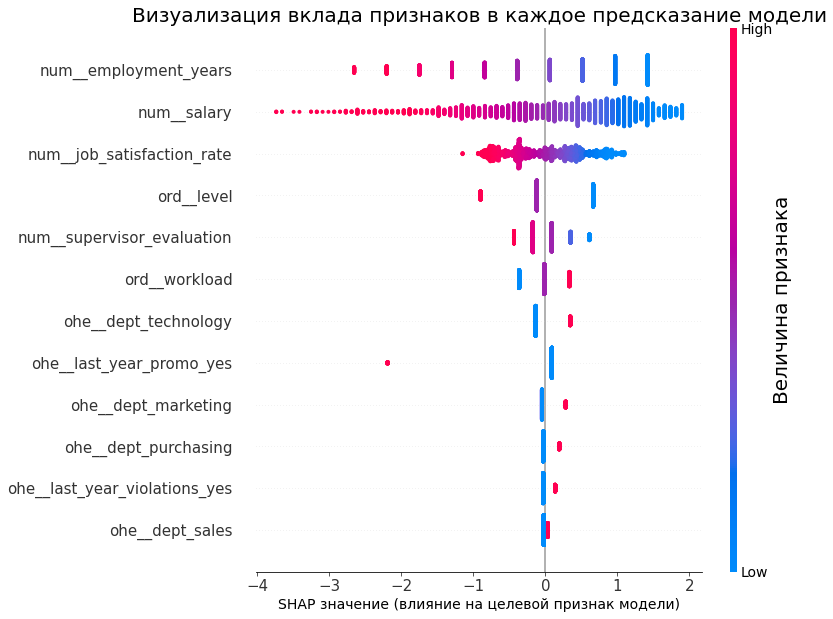

In [89]:
# Подготовим данные для Shap анализа
X_train_new = randomized_search.best_estimator_['preprocessor'].fit_transform(X_train)
model_new = randomized_search.best_estimator_['models'].fit(X_train_new, y_train)

feature_names = randomized_search.best_estimator_[:-1].get_feature_names_out()
X_train_named = pd.DataFrame(X_train_new, columns=feature_names)

explainer = shap.LinearExplainer(model_new, X_train_named)
shap_values = explainer(X_train_named)

# Визуализируем вклад признаков в каждое предсказание модели
shap.plots.beeswarm(shap_values, plot_size=(10, 10), max_display=20, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=15)
ax.set_xlabel('SHAP значение (влияние на целевой признак модели)', fontsize=14)
ax.set_title('Визуализация вклада признаков в каждое предсказание модели', fontsize=20)

cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_ylabel('Величина признака', fontsize=20)

plt.show()

Наименее важные признаки по результатам Shap-анализа являются данные по департаментам и информация о наличии нарушений договора. Попробуем удалить эти признаки из входных данных.

In [90]:
# Обозначим заново тренировочную и тестовую выборки X_train, X_test, y_train, y_test 
X_train = train_quit.drop(['quit', 'dept', 'last_year_violations'], axis=1)
y_train = train_quit['quit']
X_test = test_data.drop(['quit','id', 'dept', 'last_year_violations'], axis=1)
y_test = test_data['quit']

# обновим списки с названиями признаков
ohe_columns = ['last_year_promo']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# создадим пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore',  sparse=False))
    ]
    )

# создадим пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и ORD-кодирование
# SimpleImputer + ORD
ord_pipe = Pipeline(
    [('simple_imputer_ord_before', 
      SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
     ('ord', OrdinalEncoder(categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']], 
                            handle_unknown='use_encoded_value', unknown_value=np.nan)), 
     ('simple_imputer_ord_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [91]:
#Запустим случайный перебор моделей и гиперпараметров
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', round(randomized_search.best_score_, 3))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer_ord_before',
                      

Метрика лучшей модели на кросс-валидационной выборке возросла 0.904. Подход себя оправдал, лучшая модель теперь DecisionTreeClassifier(). Пора проверить ее на тестовых данных.

In [92]:
# проверим работу модели на тестовой выборке, для чего рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке:', round(roc_auc_score(y_test, y_test_pred[:, 1]), 3))

Метрика ROC-AUC на тестовой выборке: 0.913


Лучшая модель DecisionTreeClassifier(max_depth=4, max_features=9, random_state=42) справилась с задачей!
<br>
Метрика ROC-AUC на тестовой выборке >0.91


### Вывод по задаче №2

Для решения второй задачи мы изучили предоставленные данные, заполнили пропуски наиболее частыми значениями и подготовили для обучения моделей. Для кодировки категориальных признаков использовали два кодировщика. Затем провели обучения четырьмя моделями классификации - Логистической регрессии, Деревом решений, Методом ближайших соседей и Методом опорных векторов. Все четыре модели перебирали рандомным поиском с перебором гиперпараметров. Для оценки использовали метрику 'roc_auc'. По результатам первого случайного поиска не удалось добиться необходимого уровня 'roc_auc'.
<br>
Применив Shap-анализ мы оптимизировали набор входных данных и это дало результат. По результатам рандомного поиска лучшей моделью стала DecisionTreeClassifier с гиперпараметрами max_depth=4, max_features=9.
<br>
Метрика лучшей модели на кросс-валидационной выборке: 0.904
<br>
Метрика ROC-AUC на тестовой выборке: 0.913
<br>

## Итоговые выводы

По условиям задания нам было поставлено несколько задач:  
<br>Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.  
Для решения первой задачи мы изучили предоставленные данные, заполнили пропуски наиболее частыми значениями и подготовили для обучения моделей. Для кодировки категориальных признаков использовали два кодировщика. Затем провели обучения двумя линейными моделями - Линейной регрессии и Деревом решений, с перебором гиперпараметров. Для оценки использовали метрику SMAPE. 
<br>
По результатам рандомного поиска лучшей моделью стала DecisionTreeRegressor, с гиперпараметрами max_depth=11, max_features=12, min_samples_leaf=7, min_samples_split=13.
<br>Метрика SMAPE лучшей модели на тренировочной выборке: 12.6764
<br>Метрика SMAPE лучшей модели на тестовой выборке: 14.0466
<br>
В результате мы получили модель позволяющую предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
<br>
<br>
Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
<br>
Для решения второй задачи мы изучили предоставленные данные, заполнили пропуски наиболее частыми значениями и подготовили для обучения моделей. Для кодировки категориальных признаков использовали два кодировщика. Затем провели обучения четырьмя моделями классификации - Логистической регрессии, Деревом решений, Методом ближайших соседей и Методом опорных векторов. Все четыре модели перебирали рандомным поиском с перебором гиперпараметров. Для оценки качества моделей использовали метрику 'roc_auc'. 
<br>
По результатам первого случайного поиска не удалось добиться необходимого уровня 'roc_auc'.
Применив Shap-анализ мы оптимизировали набор входных данных и это дало результат. По результатам рандомного поиска лучшей моделью стала DecisionTreeClassifier с гиперпараметрами max_depth=4, max_features=9.
Метрика лучшей модели на кросс-валидационной выборке: 0.904
Метрика ROC-AUC на тестовой выборке: 0.913

<br>
Также мы проанализировали сотрудников которые увольняются и тех кто продолжает работать в компании. Пришли к следующим выводам:
<br>1. Высокая зарплата, высокая должность (и ее недавнее повышение) лучше всего удерживает работника от увольнения, что в свою очередь повышает постепенно его стаж работы в компании и формирует высокие оценки удовлетворенности сотрудника и оценку качества работы от его руководителя. В совокупности, это формирует пятерку самых важных признаков что подтверждается по результатам shap-анализа.
<br>2. Чаще увольняются сотрудники, которые недавно работают в компании и невысокой оценкой от руководителей. Эти факторы обуславливают также отсутствие повышений в карьере, низкую должность и невысокую зарплату. Все это в совокупности формирует у сотрудников низкий уровень удовлетворенности и те же пять важных признаков.
<br>Рекомендации Заказчику.
<br>Заказчику рекомендуется обратить внимание на критерии отбора кандидатов при приеме новых сотрудников. Значительная часть уволившихся работников была представлена специалистами завышенного профессионального уровня, чей потенциал в короткий срок прояснялся и остсутсвие перспектив роста и развития становилось очевидным.
<br>
Также рекомендуется повысить базовый уровень зарплаты для потенциальных новых работников для привлечения более квалифицированных специалистов с рынка труда.
